In [40]:
import gc
import numpy as np
import pandas as pd
import json
import argparse
import logging
import boto3
import atexit
import torch
import shutil
import os, errno, time, sys
import ipywidgets as widgets

from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import mpldatacursor
import scipy.stats as sts
import scipy as sc
import seaborn as sns
import datetime
from datetime import timedelta
import urllib.parse
from urllib.parse import urlparse

from torch.cuda import is_available
from catboost import CatBoostClassifier, Pool, cv
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import confusion_matrix
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from trains import logger
import operator
import re
import seaborn as sn
import copy

from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

import shap

In [41]:
clients = pd.read_csv('clients.csv', low_memory=False)

print("clients shape :",clients.shape)
accounts = pd.read_csv('TradeAccounts.csv', low_memory=False)
print("accounts sahpe : ",accounts.shape)
transactions = pd.read_csv('MonetaryTransactions.csv', low_memory=False)
print("transactions shape : ",transactions.shape)


clients shape : (95624, 52)
accounts sahpe :  (38864, 32)
transactions shape :  (11547, 45)


In [42]:
print("clients : ")
for col in clients.columns:
    print(col)
print("")    
print("accounts : ")
for col in accounts.columns:
    print(col)   
print("")    
print("transactions : ")
for col in transactions.columns:
    print(col)     

clients : 
Id
PublicId
CreatedDate
ModifiedDate
OwnerId
DeskId
ConvertionOwnerId
RetentionOwnerId
StatusId
Citizenship
DateOfBirth
HasDeposit
FirstDepositDate
IsEnabled
LastLoginDate
LastTradeDate
Country
City
ZipCode
State
Address
Referrer
Source
IpCountry
Tag1
Tag2
Campaignid
AffiliateId
SubAffiliateId
UtmContent
UtmSource
UtmCampaign
UtmCreative
UtmMedium
UtmTerm
AffTransactionId
Description
SubscribedNewsletter
AcceptTerms
SuppliedDocs
DeletedDate
HasTasks
TaskCreatedDate
TaskDate
AssignedDate
HasNotCompletedTasks
Type
LastCommentDate
FirstRegistrationDate
ImportId
DemoRegistrationDate
RealRegistrationDate

accounts : 
Id
ItemId
AccountId
GroupId
Leverage
StopOut
MinDeposit
OrderCount
RegistrationDate
AllowTrade
CloseProfitAndLoss
TotalDeposits
TotalWithdrawals
NetDeposit
OpenProfitAndLoss
Equity
Balance
MarginLevel
Credit
Commision
Volume
LastLoginDate
LastTradeDate
FreeMargin
MarginCall
IsOnline
Disabled
LastDepositDate
FtdDate
FtdAmount
DepositCount
TotalCredits

transactions : 

In [43]:
Deposits = pd.pivot_table(transactions,index='AccountId',values='UsdAmount',aggfunc=sum)

In [44]:
accounts_with_deposits = accounts.join(Deposits,on='Id').copy()
accounts_with_deposits['UsdAmount'].fillna(0,inplace=True)
accounts_with_deposits.head()

,Id,ItemId,AccountId,GroupId,Leverage,StopOut,MinDeposit,OrderCount,RegistrationDate,AllowTrade,CloseProfitAndLoss,TotalDeposits,TotalWithdrawals,NetDeposit,OpenProfitAndLoss,Equity,Balance,MarginLevel,Credit,Commision,Volume,LastLoginDate,LastTradeDate,FreeMargin,MarginCall,IsOnline,Disabled,LastDepositDate,FtdDate,FtdAmount,DepositCount,TotalCredits,UsdAmount
0,10142,10142,100003.0,6,200,10,100,30,2017-07-12 13:46:44.767,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-07-10 15:39:16.930,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
1,10143,10143,100004.0,6,200,10,100,30,2017-07-12 13:47:50.527,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
2,10144,10144,100005.0,6,200,10,100,30,2017-07-12 13:51:44.440,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
3,10145,10145,100006.0,6,200,10,100,30,2017-07-12 13:55:51.027,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
4,10146,10146,100007.0,6,200,10,100,30,2017-07-12 13:56:29.170,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0


In [45]:
table_of_accounts = pd.pivot_table(accounts_with_deposits,
                                   index='AccountId',
                                   values=['Id','UsdAmount'],
                                  aggfunc={'Id' : lambda x:x.shape[0],
                                           'UsdAmount' : np.sum})
table_of_accounts.rename(columns = {'Id' : 'NumberOfAccounts'},inplace=True)
table_of_accounts.head()

,NumberOfAccounts,UsdAmount
AccountId,,
100003.0,2,0.0
100004.0,1,0.0
100005.0,1,0.0
100006.0,1,0.0
100007.0,1,0.0


In [46]:
clients_with_deposits = clients.join(table_of_accounts,on='Id',rsuffix='_acounts').copy()

In [47]:
np.sum(clients_with_deposits.loc[clients_with_deposits.HasDeposit==1,'UsdAmount'].isna())

14

In [48]:
Bad_clients = clients_with_deposits.loc[(clients_with_deposits.HasDeposit==1) & (clients_with_deposits['UsdAmount'].isna())]

In [49]:
DaysForVIPs = 30
transactions['Date'] = pd.to_datetime(transactions['Date'],  format = '%Y-%m-%d %H:%M:%S')
FirstDepTable = pd.pivot_table(transactions,index='AccountId',values='Date',aggfunc=np.min)
FirstDepTable['Date'] = pd.to_datetime(FirstDepTable['Date'],  format = '%Y-%m-%d %H:%M:%S')
FirstDepTable.rename(columns = {'Date' : 'FirstDepositDate'},inplace=True)
FirstDepTable.head()
transactions = transactions.join(FirstDepTable,on='AccountId')
transactions['days_from_ftd'] = (transactions['Date']-transactions['FirstDepositDate']).dt.days
transactions_for_vip_anal = transactions.loc[transactions['days_from_ftd']<=DaysForVIPs].copy()

In [50]:
Deposits_for_vip = pd.pivot_table(transactions_for_vip_anal,index='AccountId',values='UsdAmount',aggfunc=sum)

In [51]:
accounts_with_deposits_for_vip = accounts.join(Deposits_for_vip,on='Id').copy()
accounts_with_deposits_for_vip['UsdAmount'].fillna(0,inplace=True)
accounts_with_deposits_for_vip.head()


,Id,ItemId,AccountId,GroupId,Leverage,StopOut,MinDeposit,OrderCount,RegistrationDate,AllowTrade,CloseProfitAndLoss,TotalDeposits,TotalWithdrawals,NetDeposit,OpenProfitAndLoss,Equity,Balance,MarginLevel,Credit,Commision,Volume,LastLoginDate,LastTradeDate,FreeMargin,MarginCall,IsOnline,Disabled,LastDepositDate,FtdDate,FtdAmount,DepositCount,TotalCredits,UsdAmount
0,10142,10142,100003.0,6,200,10,100,30,2017-07-12 13:46:44.767,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-07-10 15:39:16.930,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
1,10143,10143,100004.0,6,200,10,100,30,2017-07-12 13:47:50.527,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
2,10144,10144,100005.0,6,200,10,100,30,2017-07-12 13:51:44.440,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
3,10145,10145,100006.0,6,200,10,100,30,2017-07-12 13:55:51.027,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0
4,10146,10146,100007.0,6,200,10,100,30,2017-07-12 13:56:29.170,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1,0,0,NaN,NaN,NaN,0,NaN,0.0


In [52]:
table_of_accounts_for_vip = pd.pivot_table(accounts_with_deposits_for_vip,
                                   index='AccountId',
                                   values=['Id','UsdAmount'],
                                  aggfunc={'Id' : lambda x:x.shape[0],
                                           'UsdAmount' : np.sum})
table_of_accounts.rename(columns = {'Id' : 'NumberOfAccounts'},inplace=True)
clients_with_deposits_for_vip = clients.join(table_of_accounts_for_vip,on='Id',rsuffix='_acounts').copy()

In [53]:
mask = (clients_with_deposits_for_vip['HasDeposit']==1)
clients_with_deposits_for_vip = clients_with_deposits_for_vip.loc[mask]
mask = (clients_with_deposits_for_vip['UsdAmount'].isna())  
indexNames = clients_with_deposits_for_vip[mask].index
clients_with_deposits_for_vip.drop(indexNames , inplace=True)
clients_with_deposits_for_vip.loc[clients_with_deposits_for_vip.HasDeposit==1].head()
clients_with_deposits_for_vip['FirstDepositDate'] =  pd.to_datetime(clients_with_deposits_for_vip['FirstDepositDate'],format = '%Y-%m-%d %H:%M:%S')
clients_with_deposits_for_vip.sort_values(by='FirstDepositDate')

,Id,PublicId,CreatedDate,ModifiedDate,OwnerId,DeskId,ConvertionOwnerId,RetentionOwnerId,StatusId,Citizenship,DateOfBirth,HasDeposit,FirstDepositDate,IsEnabled,LastLoginDate,LastTradeDate,Country,City,ZipCode,State,Address,Referrer,Source,IpCountry,Tag1,Tag2,Campaignid,AffiliateId,SubAffiliateId,UtmContent,UtmSource,UtmCampaign,UtmCreative,UtmMedium,UtmTerm,AffTransactionId,Description,SubscribedNewsletter,AcceptTerms,SuppliedDocs,DeletedDate,HasTasks,TaskCreatedDate,TaskDate,AssignedDate,HasNotCompletedTasks,Type,LastCommentDate,FirstRegistrationDate,ImportId,DemoRegistrationDate,RealRegistrationDate,Id_acounts,UsdAmount
22,100025,AC100025,2017-07-24 11:21:39.320,2019-04-06 07:07:58.173,44,57,NaN,NaN,NaN,NaN,NaN,1,2017-07-24 11:22:14.000,1,2017-09-18 08:59:10.000,NaN,CY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,2,NaN,2017-07-24 11:21:39.320,NaN,2017-07-24 11:22:14.717,NaN,1.0,10000.0000
16,100019,AC100019,2017-07-20 15:20:18.170,2019-04-06 07:07:58.173,44,57,NaN,36.0,NaN,NaN,NaN,1,2017-08-10 07:44:35.000,1,2017-09-27 10:13:43.000,NaN,IL,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-07-20 15:20:18.170,NaN,NaN,2017-07-20 15:20:18.123,1.0,10000.0000
70,100076,AC100076,2017-08-21 06:45:59.173,2019-04-06 07:07:58.173,44,57,NaN,44.0,NaN,NaN,NaN,1,2017-08-21 06:47:59.000,1,NaN,NaN,SA,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-08-21 06:45:59.173,NaN,NaN,2017-08-21 06:45:59.127,1.0,3260.0000
75,100081,AC100081,2017-08-23 09:23:08.700,2019-04-06 07:07:58.173,44,57,NaN,44.0,NaN,NaN,NaN,1,2017-08-23 09:25:02.000,1,NaN,NaN,ZA,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,ZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-08-23 09:23:08.700,NaN,NaN,2017-08-23 09:23:08.653,1.0,6000.0000
105,100112,AC100112,2017-08-30 14:46:47.450,2019-04-06 07:07:58.173,44,57,NaN,44.0,NaN,NaN,NaN,1,2017-08-30 14:50:02.000,1,NaN,NaN,SA,NaN,NaN,NaN,NaN,https://www.12trader.com/ar/,NaN,SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-08-30 14:46:47.450,NaN,NaN,2017-08-30 14:46:47.403,1.0,2500.0000
133,100140,AC100140,2017-09-07 10:28:31.910,2019-04-06 07:07:58.173,44,57,NaN,36.0,NaN,NaN,NaN,1,2017-09-07 11:36:24.000,1,2017-09-13 14:48:59.000,NaN,SA,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-09-07 10:28:31.910,NaN,NaN,2017-09-07 10:28:31.910,1.0,17000.0000
169,100176,AC100176,2017-09-19 07:18:17.257,2019-04-06 07:07:58.173,44,57,NaN,44.0,NaN,NaN,NaN,1,2017-09-19 07:21:13.000,1,NaN,NaN,ZA,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,ZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-09-19 07:18:17.257,NaN,NaN,2017-09-19 07:18:17.210,1.0,6000.0000
174,100181,AC100181,2017-09-20 08:05:13.190,2019-04-06 07:07:58.173,44,57,NaN,44.0,NaN,NaN,NaN,1,2017-09-20 08:06:58.000,1,NaN,NaN,ZA,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,ZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-09-20 08:05:13.190,NaN,NaN,2017-09-20 08:05:13.157,1.0,7000.0000
158,100165,AC100165,2017-09-13 14:56:29.473,2019-04-06 07:07:58.173,44,57,36.0,NaN,NaN,NaN,NaN,1,2017-09-21 15:56:49.683,1,NaN,NaN,DE,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-09-13 14:56:29.473,NaN,NaN,2017-09-13 14:56:29.457,1.0,5000.0000
106,100113,AC100113,2017-08-31 09:17:09.980,2019-04-06 07:07:58.173,44,57,36.0,NaN,NaN,NaN,NaN,1,2017-09-21 15:56:49.683,1,NaN,NaN,GB,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-08-31 09:17:09.980,NaN,NaN

In [54]:
clients_with_deposits_for_vip['date'] = clients_with_deposits_for_vip['FirstDepositDate'].dt.date

In [71]:
clients_with_deposits_for_vip['IsVIP'] = np.zeros_like(clients_with_deposits_for_vip['date'])
Prices = []
dates = []
for day in clients_with_deposits_for_vip['date']:
    mask = (clients_with_deposits_for_vip['date']>=day) & (clients_with_deposits_for_vip['date']<=day+timedelta(days=60))
    if np.sum(mask)>0:
        PriceGroup = clients_with_deposits_for_vip.loc[mask,'UsdAmount'].values
        VIP_Price = np.percentile(PriceGroup,90)
        Prices.append(VIP_Price)
        dates.append(day)
        mask2 = clients_with_deposits_for_vip['date']==day
        mask3 = clients_with_deposits_for_vip['UsdAmount']>=VIP_Price
        clients_with_deposits_for_vip.loc[mask2&mask3,'IsVIP'] = 1

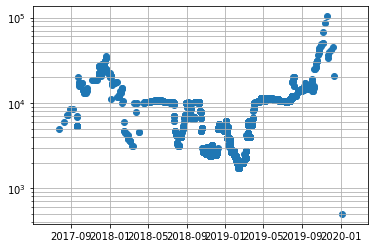

In [77]:
plt.scatter(dates,Prices)
plt.yscale('log')
plt.grid('both',which='both')

In [65]:
np.sum(clients_with_deposits_for_vip.IsVIP)/np.sum(clients_with_deposits_for_vip.HasDeposit)

0.10335917312661498

In [66]:
clients_with_deposits = clients_with_deposits.join(clients_with_deposits_for_vip[['Id','IsVIP']].set_index('Id'),on='Id')

In [67]:
clients_with_deposits['IsVIP'].fillna(0,inplace=True)

In [69]:
clients_with_deposits.head()

,Id,PublicId,CreatedDate,ModifiedDate,OwnerId,DeskId,ConvertionOwnerId,RetentionOwnerId,StatusId,Citizenship,DateOfBirth,HasDeposit,FirstDepositDate,IsEnabled,LastLoginDate,LastTradeDate,Country,City,ZipCode,State,Address,Referrer,Source,IpCountry,Tag1,Tag2,Campaignid,AffiliateId,SubAffiliateId,UtmContent,UtmSource,UtmCampaign,UtmCreative,UtmMedium,UtmTerm,AffTransactionId,Description,SubscribedNewsletter,AcceptTerms,SuppliedDocs,DeletedDate,HasTasks,TaskCreatedDate,TaskDate,AssignedDate,HasNotCompletedTasks,Type,LastCommentDate,FirstRegistrationDate,ImportId,DemoRegistrationDate,RealRegistrationDate,NumberOfAccounts,UsdAmount,IsVIP
0,100002,AC100002,2017-07-12 13:20:37.340,2019-11-22 11:53:12.610,228,37,44.0,NaN,NaN,NaN,NaN,1,2017-12-16 10:03:38.207,1,NaN,NaN,UA,NaN,NaN,NaN,NaN,https://www.12trader.com/real,NaN,UA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,NaN,0,NaN,NaN,2019-04-08 14:23:51.000,0,1,NaN,2017-07-12 13:20:37.340,NaN,NaN,NaN,NaN,NaN,0.0
1,100003,AC100003,2017-07-12 13:46:44.767,2019-04-06 07:07:58.173,44,57,NaN,NaN,NaN,NaN,NaN,0,NaN,1,2017-10-05 09:34:49.000,NaN,BG,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,BG,NaN,SitePromoBanner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-07-12 13:46:44.767,NaN,NaN,2017-07-12 13:46:44.767,2.0,0.0,0.0
2,100004,AC100004,2017-07-12 13:47:50.540,2019-04-06 07:07:58.173,44,57,NaN,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN,IL,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-07-12 13:47:50.540,NaN,NaN,2017-07-12 13:47:50.527,1.0,0.0,0.0
3,100005,AC100005,2017-07-12 13:51:44.453,2019-04-06 07:07:58.173,44,57,NaN,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN,IL,NaN,NaN,NaN,NaN,https://www.12trader.com/,NaN,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-07-12 13:51:44.453,NaN,NaN,2017-07-12 13:51:44.440,1.0,0.0,0.0
4,100006,AC100006,2017-07-12 13:55:51.043,2019-04-06 07:07:58.173,44,57,NaN,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN,IL,NaN,NaN,NaN,NaN,https://www.12trader.com/Home,NaN,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,3,NaN,2017-07-12 13:55:51.043,NaN,NaN,2017-07-12 13:55:51.027,1.0,0.0,0.0


In [70]:
clients_with_deposits.to_csv('Clinets_for_VIP.csv')